Comment utiliser le pipeline de sk learn

In [53]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder, OneHotEncoder, Binarizer, PolynomialFeatures,MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV

import seaborn as sns

import pandas as pd 
import numpy as np 

dataframe = pd.read_csv("dataset.csv", sep=",", index_col=False)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [54]:
# bins = [0, 18.5, 25, 30, 35, 40, float('inf')]
# labels = ['Poids insuffisant', 'Poids normal', 'Surpoids', 'Obésité grade I', 'Obésité grade II', 'Obésité grade III']

# # Remplacer le bmi_encoder par la catégorisation d'IMC
# dataframe['bmi_category'] = pd.cut(dataframe['bmi'], bins=bins, labels=labels, right=False)

# # Encodage numérique des catégories d'IMC
# category_mapping = {
#     'Poids insuffisant': 0,
#     'Poids normal': 1,
#     'Surpoids': 2,
#     'Obésité grade I': 3,
#     'Obésité grade II': 4,
#     'Obésité grade III': 5
# }
# dataframe['bmi_encoded'] = dataframe['bmi_category'].map(category_mapping)

In [55]:
#dataframe = dataframe[ dataframe['charges'] <= 60000]

y = dataframe['charges']
X = dataframe.drop('charges', axis=1)

# pour pouvoir comparer le score
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])


In [56]:
from bmi_transformer import BmiTransformer

bmi_thresholds = [0, 18.5, 25, 30, 35, 40]
bmi_transformer = BmiTransformer(bins = bmi_thresholds)

#bmi_pipeline  = Binarizer(threshold=30)
#bmi_pipeline  = make_pipeline(bmi_transformer, OneHotEncoder())

#bmi_pipeline  = make_union(Binarizer(threshold=30), StandardScaler())
bmi_pipeline = make_union( make_pipeline(bmi_transformer, OneHotEncoder()), StandardScaler())


In [57]:
preprocessor = make_pipeline( 
    make_column_transformer(
        (StandardScaler(), ['age']),
        (OrdinalEncoder(categories=[['female', 'male']]), ['sex']),
        (bmi_pipeline, ['bmi']),
        (OrdinalEncoder(categories=[['no', 'yes']]), ['smoker']),
        (StandardScaler(), ['children']), 
        (OneHotEncoder(), ['region']), 
        remainder='passthrough'),
    PolynomialFeatures(degree=2))
    

In [58]:
model1 = make_pipeline(preprocessor, LassoCV(cv=5))
#model = make_pipeline(preprocessor, Lasso(alpha=39))
model1

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('standardscaler-1',
                                                                   StandardScaler(),
                                                                   ['age']),
                                                                  ('ordinalencoder-1',
                                                                   OrdinalEncoder(categories=[['female',
                                                                                               'male']]),
                                                                   ['sex']),
                                                                  ('featureunion',
                                                                   FeatureUnion(transformer_list=[('pipeline',
                                                                                                   Pipeline(steps=[('bmitransformer',
                                                                                                                    BmiTransformer...
                                                                                                                                         18.5,
                                                                                                                                         25,
                                                                                                                                         30,
                                                                                                                                         35,
                                                                                                                                         40])),
                                                                                                                   ('onehotencoder',
                                                                                                                    OneHotEncoder())])),
                                                                                                  ('standardscaler',
                                                                                                   StandardScaler())]),
                                                                   ['bmi']),
                                                                  ('ordinalencoder-2',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'yes']]),
                                                                   ['smoker']),
                                                                  ('standardscaler-2',
                                                                   StandardScaler(),
                                                                   ['children']),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(),
                                                                   ['region'])])),
                                 ('polynomialfeatures',
                                  PolynomialFeatures())])),
                ('lassocv', LassoCV(cv=5))])

In [59]:

model1.fit(X_train, y_train)
score = model1.score(X_test, y_test)
print(f"  score  = {score} ")

  score  = 0.8752511301995037 


Avec le meilleur alpha :

In [60]:
from sklearn.model_selection import GridSearchCV

#dataframe = dataframe [dataframe['charges']<=60000]

X = dataframe.drop('charges', axis=1)
y = dataframe['charges']   

# pour pouvoir comparer le score
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])

#X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, train_size=0.85, random_state=42)

model2 = make_pipeline(
    preprocessor, 
    #PolynomialFeatures(degree=2, include_bias=False),  
    Lasso()  # Modèle Lasso
    #LinearRegression()
)

param_grid = {'lasso__alpha':np.arange(15, 60, 1)}
#param_grid = {'linearregression__alpha':np.arange(20, 40, 1)}

grid_search = GridSearchCV(model2, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Meilleurs paramètres :", grid_search.best_params_)
best_model = grid_search.best_estimator_
score = best_model.score(X_test, y_test)
print(f"  score  = {score} ")

# model = Lasso(alpha=grid_search.best_params_['lasso__alpha'])

# #coeffiscients
# for i in range(len(X_train.columns.array)):
#     colname = X_train.columns.array[i]
#     coeff = model.coef_[i]
#     print(f"{colname} : {coeff}")

Meilleurs paramètres : {'lasso__alpha': np.int64(33)}
  score  = 0.8752500825435601 


In [61]:
y_predicted = best_model.predict(X_test)

import sklearn.metrics as skl_metrics

rmse = skl_metrics.root_mean_squared_error(y_test, y_predicted)
Rsquare = skl_metrics.r2_score(y_test, y_predicted)

print(f"r2_score = {Rsquare} ")
print(f"sklearn.metrics.mean_squared_error = {rmse}")


r2_score = 0.8752500825435601 
sklearn.metrics.mean_squared_error = 4273.733905571395


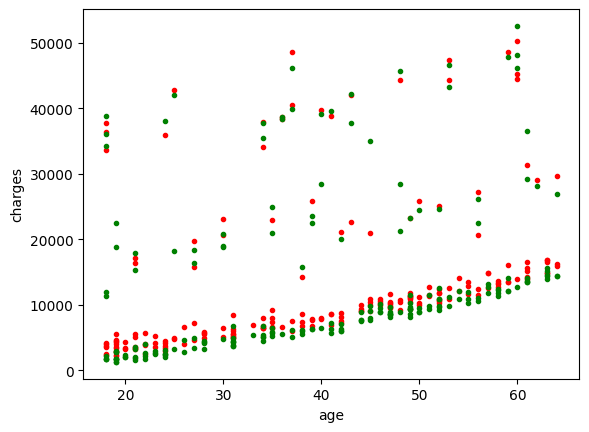

In [62]:
import matplotlib.pyplot as plt

#Charges = f ( age )
plt.xlabel("age")
plt.ylabel("charges")
plt.plot(X_test["age"], y_predicted, "r.")
plt.plot(X_test["age"], y_test, "g.")
plt.show()

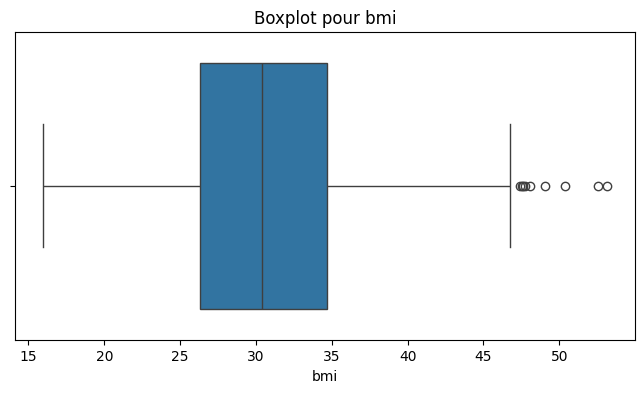

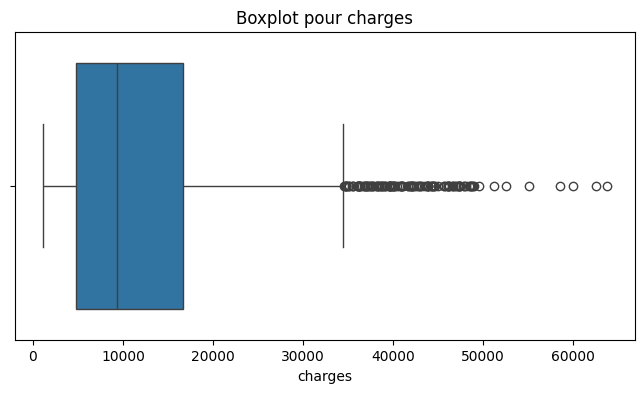

In [63]:
columns_to_check = ['bmi', 'charges']

for col in columns_to_check:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=dataframe[col])
    plt.title(f"Boxplot pour {col}")
    plt.show()

In [64]:
# Fonction pour repérer les valeurs aberrantes basées sur l'IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Repérer les valeurs aberrantes dans `bmi` et `charges`
outliers_bmi = detect_outliers_iqr(dataframe, 'bmi')
outliers_charges = detect_outliers_iqr(dataframe, 'charges')

print("Valeurs aberrantes dans bmi :")
print(outliers_bmi)

print("\nValeurs aberrantes dans charges :")
print(outliers_charges)


Valeurs aberrantes dans bmi :
      age     sex    bmi  children smoker     region      charges
116    58    male  49.06         0     no  southeast  11381.32540
286    46  female  48.07         2     no  northeast   9432.92530
401    47    male  47.52         1     no  southeast   8083.91980
543    54  female  47.41         0    yes  southeast  63770.42801
847    23    male  50.38         1     no  southeast   2438.05520
860    37  female  47.60         2    yes  southwest  46113.51100
1047   22    male  52.58         1    yes  southeast  44501.39820
1088   52    male  47.74         1     no  southeast   9748.91060
1317   18    male  53.13         0     no  southeast   1163.46270

Valeurs aberrantes dans charges :
      age     sex     bmi  children smoker     region      charges
14     27    male  42.130         0    yes  southeast  39611.75770
19     30    male  35.300         0    yes  southwest  36837.46700
23     34  female  31.920         1    yes  northeast  37701.87680
29     

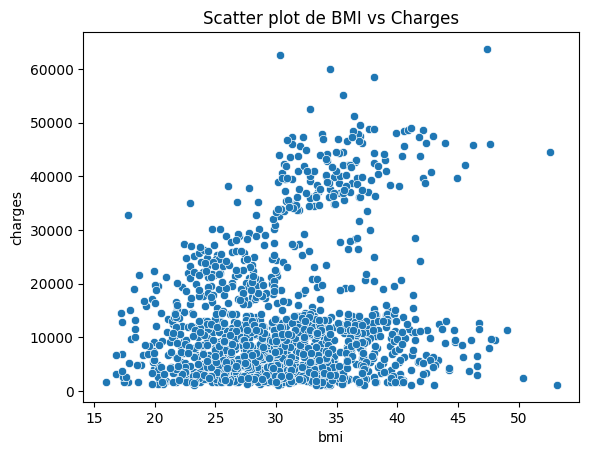

In [65]:
sns.scatterplot(data=dataframe, x='bmi', y='charges')
plt.title("Scatter plot de BMI vs Charges")
plt.show()


In [66]:
dataframe_cleaned = dataframe [dataframe['charges']<=60000]